In [42]:
import pandas as pd
from hydra import initialize, compose
from pathlib import Path
import json
from ergochemics.draw import draw_reaction, draw_molecule
from ergochemics.mapping import operator_map_reaction
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import AllChem

In [2]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

In [4]:
mm = pd.read_parquet(
    Path(cfg.raw_data) / "mapped_mech_labeled_reactions.parquet"
)
mm.head()

,entry_id,mechanism_id,smarts,am_smarts,rule,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec
0,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[CH:1]([CH2:3][CH2:2][C:4](=[O:9])[OH:10])([NH...,[#6:1]-[#6:2]-[#6:3]-[#6:4]>>[#6:1]-[#6:3]-[#6...,"[[[1, 2, 3, 4]], [[0, 1, 2, 3]]]","[[0, 1, 2, 3]]",glutamate racemase,P56868,5.1.1.3
1,2,2,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[N:1]12[C:2](=[O:5])[CH:4]([NH:6][C:8]([*:10])...,[#6:1]-[#7:2].[#8:3]>>([#7:2].[#6:1]-[#8:3]),"[[[5, 7], [0]], [[0, 1, 2]]]","[[5, 6, 7], [0]]",beta-lactamase (Class A),P62593,3.5.2.6
2,2,1,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[N:1]12[C:2](=[O:5])[CH:4]([NH:6][C:8]([*:10])...,[#6:1]-[#7:2].[#8:3]>>([#7:2].[#6:1]-[#8:3]),"[[[5, 7], [0]], [[0, 1, 2]]]","[[5, 6, 7], [0]]",beta-lactamase (Class A),P62593,3.5.2.6
3,6,1,NC(CCC(=O)NC(CSSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCC...,[S:1]([CH2:2][CH:3]([NH:4][C:6]([CH2:9][CH2:12...,[#16:1]-[#16:2].[#6:3]1=[#6:4]-[#7:5]-[#6:6]=[...,"[[[9, 10], [3, 4, 5, 45, 46, 47]], [[0], [0], ...","[[9, 10], [14, 15, 16, 20]]",glutathione-disulfide reductase,P00390,1.8.1.7
4,7,2,NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC...,[c:11]1([C:17]([NH2:18])=[O:19])[cH:12][n+:13]...,[#6:1]1:[#6:2]:[#6:3]:[#6:4]:[#7+:5]:[#6:6]:1....,"[[[3, 4, 5, 6, 7, 47], [7, 5, 4, 8, 9]], [[0, ...","[[14, 15, 16, 20], [3, 4, 6, 8, 9, 10]]",isocitrate dehydrogenase (NADP+),P08200,1.1.1.42


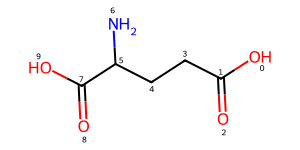

In [54]:
smi = 'OC(=O)CCC(N)C(=O)O'
mol = Chem.MolFromSmiles(smi)
SVG(draw_molecule(mol, size=(300, 150), draw_options={"addAtomIndices": True}))

In [55]:
Chem.MolFragmentToSmarts(mol, atomsToUse=[0, 1, 3, 5, 6])

'[#8]-[#6]-[#6].[#6]-[#7]'

In [56]:
Chem.GetShortestPath(mol, 3, 5)

(3, 4, 5)

In [57]:
Chem.GetAdjacencyMatrix(mol, useBO=True)[[0, 1, 3, 5, 6]][:, [0, 1, 3, 5, 6]]

array([[0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

[16:57:34] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 4 


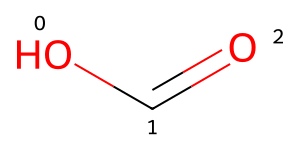

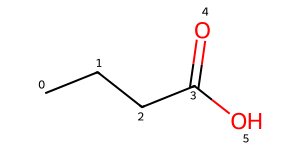

In [58]:
rule = '([O:1]-[C:2]-[C:3].[N:4])>>[O:1]-[C:2].[C:3]'
op = AllChem.ReactionFromSmarts(rule)
for elt in op.RunReactants([mol])[0]:
    display(SVG(draw_molecule(elt, size=(300, 150), draw_options={"addAtomIndices": True})))

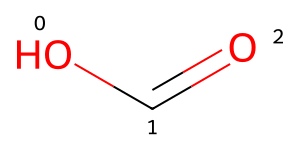

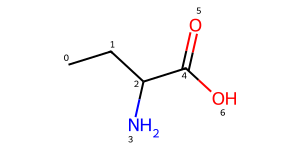

In [ ]:
# This looks like the winner
# I will have to be careful about bonds between included atoms
# and not included atoms. Depending on the atomic invariants
# the order of these bonds may be specified and not wildcard
rule = '[O:1]-[C:2]-[C:3]~[*:4]~[*:5]~[N:6]>>[O:1]-[C:2].[C:3]~[*:4]~[*:5]~[N:6]'
op = AllChem.ReactionFromSmarts(rule)
for elt in op.RunReactants([mol])[0]:
    display(SVG(draw_molecule(elt, size=(300, 150), draw_options={"addAtomIndices": True})))

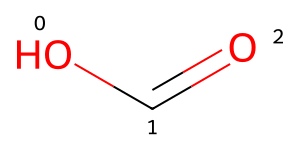

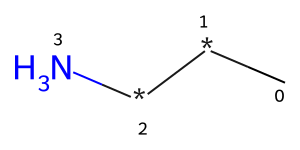

In [60]:
rule = '[O:1]-[C:2]-[C:3]~*~*~[N:6]>>[O:1]-[C:2].[C:3]~*~*~[N:6]'
op = AllChem.ReactionFromSmarts(rule)
for elt in op.RunReactants([mol])[0]:
    display(SVG(draw_molecule(elt, size=(300, 150), draw_options={"addAtomIndices": True})))

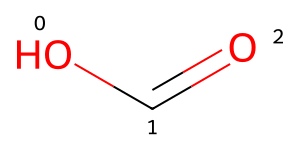

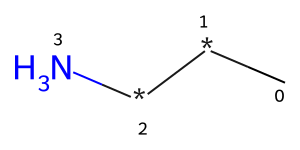

In [61]:
rule = '[O:1]-[C:2]-[C:3]~*~*~N>>[O:1]-[C:2].[C:3]~*~*~N'
op = AllChem.ReactionFromSmarts(rule)
for elt in op.RunReactants([mol])[0]:
    display(SVG(draw_molecule(elt, size=(300, 150), draw_options={"addAtomIndices": True})))